## 라이브러리 임포트

In [1]:
# 이미지 처리를 위한 OpenCV 라이브러리
import cv2
# 다차원 배열 및 행렬 연산을 위한 NumPy 라이브러리
import numpy as np
# 딥러닝 프레임워크 PyTorch
import torch
# 이미지 변환을 위한 torchvision.transforms
import torchvision.transforms as T
# DeepLabV3 모델 불러오기
from torchvision.models.segmentation import deeplabv3_resnet101
# 사전 학습된 가중치 불러오기
from torchvision.models.segmentation import DeepLabV3_ResNet101_Weights

# 이미지 시각화를 위한 Matplotlib
import matplotlib.pyplot as plt

# OpenCV 버전 확인
print(cv2.__version__)

4.11.0


## 이미지 불러오기 및 확인

원본 고양이 이미지 크기: (1125, 900, 3)
배경(사막) 이미지 크기: (1350, 900, 3)
사람 이미지 크기: (5712, 4284, 3)


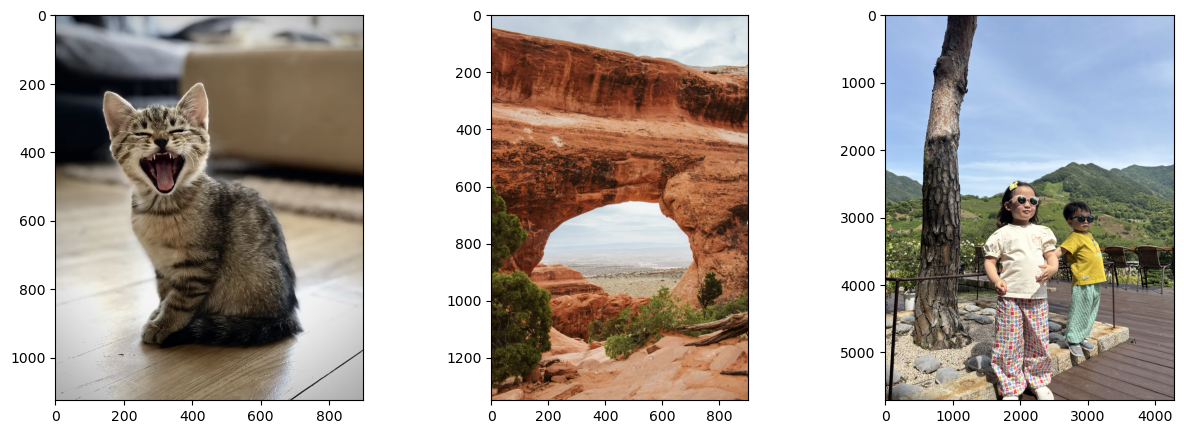

In [2]:
# 고양이 이미지 경로
cat_img_path = "images/cat.png"
# 배경 이미지 경로
sand_img_path = "images/sand.png"
# 사람 이미지 경로
person_img_path = "images/person.png"

# OpenCV로 고양이 이미지 읽기
cat_img = cv2.imread(cat_img_path)
# OpenCV로 배경 이미지 읽기
sand_img = cv2.imread(sand_img_path)
# OpenCV로 사람 이미지 읽기
person_img = cv2.imread(person_img_path)

# BGR을 RGB로 색상 공간 변환 (Matplotlib 시각화를 위함)
cat_img = cv2.cvtColor(cat_img, cv2.COLOR_BGR2RGB)
sand_img = cv2.cvtColor(sand_img, cv2.COLOR_BGR2RGB)
person_img = cv2.cvtColor(person_img, cv2.COLOR_BGR2RGB)

# 각 이미지의 크기(shape) 출력
print(f"원본 고양이 이미지 크기: {cat_img.shape}")
print(f"배경(사막) 이미지 크기: {sand_img.shape}")
print(f"사람 이미지 크기: {person_img.shape}")

# 시각화할 그림(figure) 크기 설정
plt.figure(figsize=(15, 5))

# 1행 3열의 첫 번째 위치에 서브플롯 생성
plt.subplot(1, 3, 1)
plt.imshow(cat_img) # 고양이 이미지 표시

# 1행 3열의 두 번째 위치에 서브플롯 생성
plt.subplot(1, 3, 2)
plt.imshow(sand_img) # 배경 이미지 표시

# 1행 3열의 세 번째 위치에 서브플롯 생성
plt.subplot(1, 3, 3)
plt.imshow(person_img) # 사람 이미지 표시

# 이미지들을 화면에 출력
plt.show()

## 모델 및 전처리기(Transform) 정의

In [3]:
# 사전 학습된 DeepLabV3-ResNet101 모델의 기본 가중치 가져오기
weights = DeepLabV3_ResNet101_Weights.DEFAULT
# 가중치를 적용하여 모델을 생성하고, 평가 모드로 설정
model = deeplabv3_resnet101(weights=weights).eval()

# 이미지 전처리 파이프라인 정의
transform = T.Compose([
    # NumPy 배열(OpenCV 이미지)을 PIL 이미지로 변환
    T.ToPILImage(),
    # 모델의 입력 크기에 맞게 이미지 크기 조정
    T.Resize((520, 520)),
    # PIL 이미지를 PyTorch 텐서로 변환
    T.ToTensor(),
])

## 1. 고양이 이미지 분할 (Segmentation)

추론 마스크 크기 (Before Resize): (520, 520)
추론 마스크 크기 (After Resize): (1125, 900)
예측된 클래스 ID: [0 8]


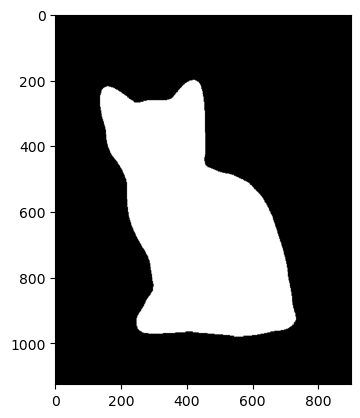

In [4]:
# 사람 이미지에 전처리 적용 후, 배치 차원 추가
input_tensor = transform(cat_img).unsqueeze(0)

# 기울기 계산 비활성화
with torch.no_grad():
    # 모델 추론
    output = model(input_tensor)["out"][0]
    # 분할 마스크 생성
    output_predictions = output.argmax(0).byte().cpu().numpy()

# 리사이즈 전 마스크 크기 출력
print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

# 마스크를 원본 이미지 크기로 조정
output_predictions_resized = cv2.resize(output_predictions, (cat_img.shape[1], cat_img.shape[0]), interpolation=cv2.INTER_NEAREST)
# 리사이즈 후 마스크 크기 출력
print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

# 마스크에 존재하는 고유한 클래스 ID 확인
unique_classes = np.unique(output_predictions_resized)
# 예측된 클래스 ID 출력
print(f"예측된 클래스 ID: {unique_classes}")

# 대상 클래스 ID 선택
target_class_id = unique_classes[-1]

# 대상 클래스 픽셀만 True로 표시
seg_map = (output_predictions_resized == target_class_id)
# 0/255 값의 마스크 이미지로 변환
img_mask = seg_map.astype(np.uint8) * 255

# 생성된 마스크 시각화
plt.imshow(img_mask, cmap='gray')
# 이미지 출력
plt.show()

## 2. 고양이 이미지 배경 블러 처리

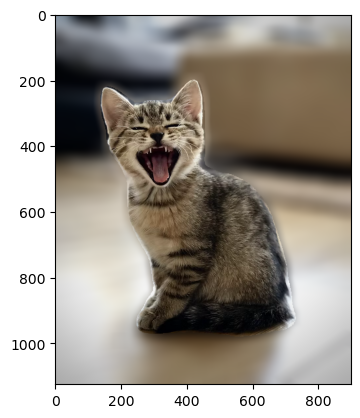

In [5]:
# 원본 고양이 이미지에 블러 효과 적용
cat_blur = cv2.blur(cat_img, (50, 50))

# 흑백 마스크를 컬러(3채널) 이미지로 변환
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# 마스크가 255(고양이)인 부분은 원본 이미지를, 아닌 부분은 블러 처리된 이미지를 사용
result_img = np.where(img_mask_color == 255, cat_img, cat_blur)

# 최종 결과 이미지 시각화
plt.imshow(result_img)
# 이미지 출력
plt.show()

## 3. 고양이 이미지 배경 교체

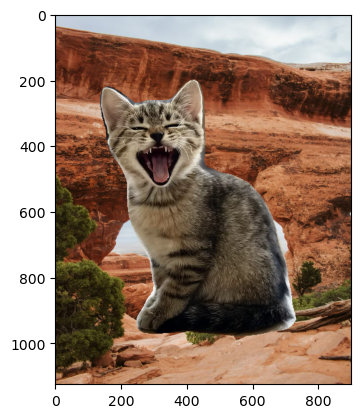

In [6]:
# 배경 이미지를 고양이 이미지 크기에 맞게 리사이즈
sand_img_resized = cv2.resize(sand_img, (cat_img.shape[1], cat_img.shape[0]))

# 흑백 마스크를 컬러(3채널) 이미지로 변환
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
# 마스크가 255(고양이)인 부분은 원본 이미지를, 아닌 부분은 새로운 배경 이미지를 사용
result_img = np.where(img_mask_color == 255, cat_img, sand_img_resized)

# 최종 결과 이미지 시각화
plt.imshow(result_img)
# 이미지 출력
plt.show()

## 4. 사람 이미지 분할 (Segmentation)

In [7]:
def get_segmentation(img):
    """
    위에서 썼던 세그멘테이션 분리하는 기능을 메소드 화

    Args:
        img : 세그멘테이션 할 이미지

    Returns:
        img_mask : 세그멘테이션 결과 마스크 이미지
    """
    # 이미지에 전처리 적용 후, 배치 차원 추가
    input_tensor = transform(img).unsqueeze(0)

    # 기울기 계산 비활성화
    with torch.no_grad():
        # 모델 추론
        output = model(input_tensor)["out"][0]
        # 분할 마스크 생성
        output_predictions = output.argmax(0).byte().cpu().numpy()

    # 리사이즈 전 마스크 크기 출력
    print(f"추론 마스크 크기 (Before Resize): {output_predictions.shape}")

    # 마스크를 원본 이미지 크기로 조정
    output_predictions_resized = cv2.resize(output_predictions, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    # 리사이즈 후 마스크 크기 출력
    print(f"추론 마스크 크기 (After Resize): {output_predictions_resized.shape}")

    # 마스크에 존재하는 고유한 클래스 ID 확인
    unique_classes = np.unique(output_predictions_resized)
    # 예측된 클래스 ID 출력
    print(f"예측된 클래스 ID: {unique_classes}")

    # 대상(사람) 클래스 ID 선택
    target_class_id = unique_classes[-1]

    # 대상 클래스 픽셀만 True로 표시
    seg_map = (output_predictions_resized == target_class_id)
    # 0/255 값의 마스크 이미지로 변환
    img_mask = seg_map.astype(np.uint8) * 255

    # 생성된 마스크 시각화
    plt.imshow(img_mask, cmap='gray')
    # 이미지 출력
    plt.show()
    
    # 리사이즈된 마스크를 반환
    return img_mask

추론 마스크 크기 (Before Resize): (520, 520)
추론 마스크 크기 (After Resize): (5712, 4284)
예측된 클래스 ID: [ 0  9 15]


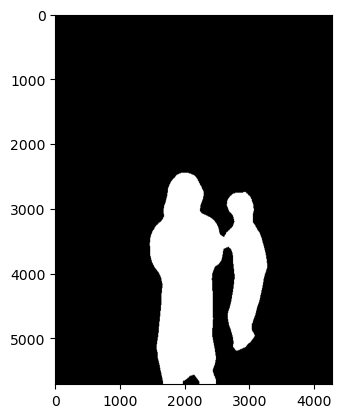

In [8]:
# 위에 메소드로 세그멘테이션 수행
img_mask_person = get_segmentation(person_img)

## 5. 사람 이미지 배경 블러 처리

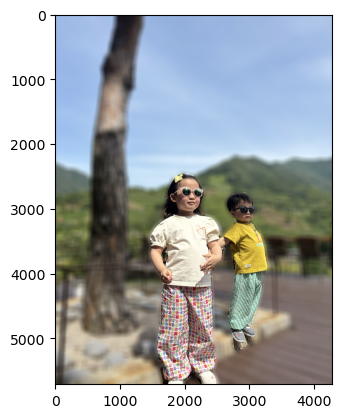

In [9]:
# 이미지에 블러 효과 적용
person_blur = cv2.blur(person_img, (100, 100))

# 흑백 마스크를 컬러(3채널)로 변환
img_mask_color = cv2.cvtColor(img_mask_person, cv2.COLOR_GRAY2BGR)
# 마스크를 이용해 사람만 남기고 배경은 블러 처리
result_img = np.where(img_mask_color == 255, person_img, person_blur)

# 최종 결과 이미지 시각화
plt.imshow(result_img)
# 이미지 출력
plt.show()

## 6. MediaPipe를 이용한 인물 사진 만들기 (추가 실험)
DeepLabV3 모델이 사람을 정확하게 감지하지 못하는 문제를 해결하기 위해, 사람 분할에 특화된 MediaPipe 라이브러리를 사용

In [10]:
# MediaPipe 라이브러리 설치
# !pip install mediapipe

In [11]:
# MediaPipe 라이브러리 임포트
import mediapipe as mp

# MediaPipe Selfie Segmentation 모델 준비
mp_selfie_segmentation = mp.solutions.selfie_segmentation
# 0: 일반 모델 (셀피 같은 어깨 위로 올라온 사진에 최적화)
# 1: 단체사진용 모델 (풍경에 최적화된 모델)
selfie_segmentation = mp_selfie_segmentation.SelfieSegmentation(model_selection=0)

I0000 00:00:1753773420.059444 44579251 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M3


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1753773420.075308 44579963 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


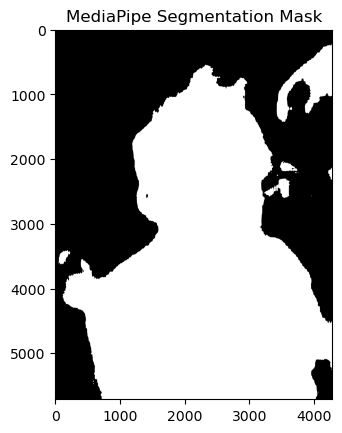

In [12]:
# 이미지 불러오기
hard_img_path = 'images/hard-to-recognize.png'
hard_img = cv2.imread(hard_img_path)
hard_img = cv2.cvtColor(hard_img, cv2.COLOR_BGR2RGB)

# Selfie Segmentation 모델로 사람 분할 처리
results = selfie_segmentation.process(hard_img)

# 분할 마스크(segmentation mask) 가져오기
# 각 픽셀이 사람일 확률이 0.8 이상이면 사람으로 판단
condition = np.stack((results.segmentation_mask,) * 3, axis=-1) > 0.8

# 마스크 시각화를 위해 0/255 값으로 변환
img_mask_mp = np.where(condition, 255, 0).astype(np.uint8)

# 생성된 마스크 시각화
plt.imshow(img_mask_mp, cmap='gray')
plt.title('MediaPipe Segmentation Mask')
plt.show()

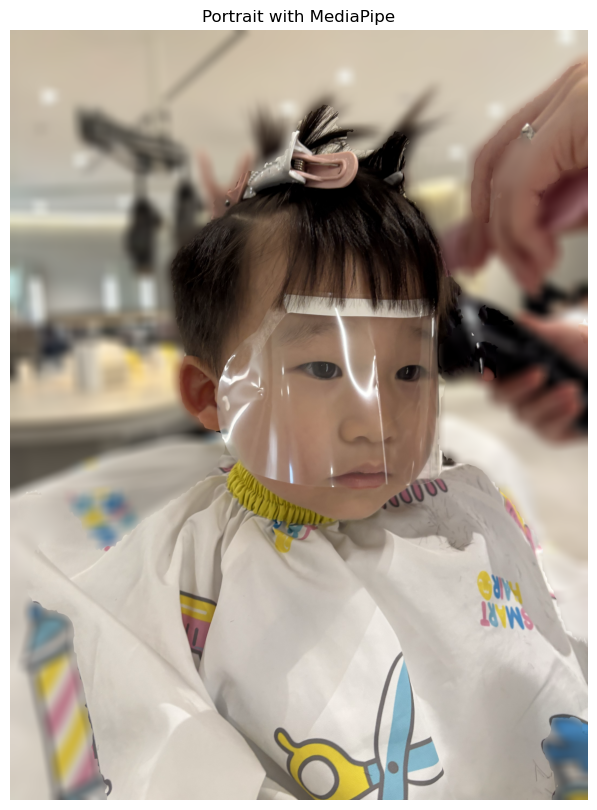

In [13]:
# 배경 블러 처리
hard_blur_mp = cv2.blur(hard_img, (100, 100))

# 원본 이미지와 블러 처리된 배경 합성
result_img_mp = np.where(condition, hard_img, hard_blur_mp)

# 최종 결과 이미지 시각화
plt.figure(figsize=(10, 10))
plt.imshow(result_img_mp)
plt.title('Portrait with MediaPipe')
plt.axis('off')
plt.show()

## 7. 마스크 다듬기 (Morphology 연산)
MediaPipe가 생성한 마스크에서 발생하는 작은 구멍이나 거친 경계면 다듬어서 자연스럽게 처리하기

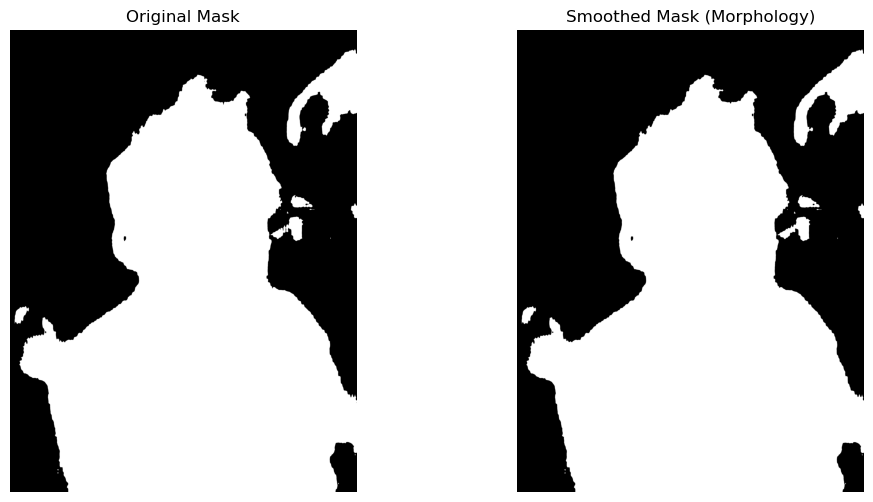

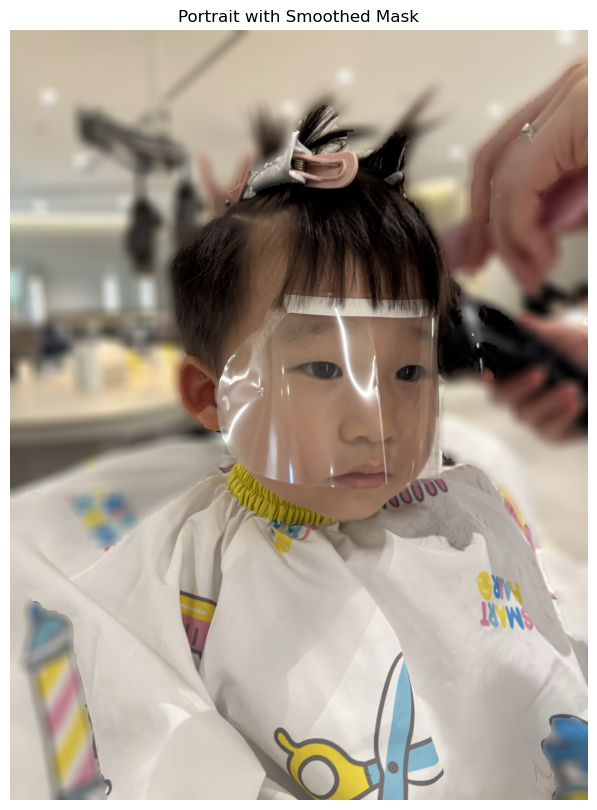

In [14]:
# 기존 마스크를 0/255 흑백 이미지로 변환
mask_img = (results.segmentation_mask > 0.8).astype(np.uint8) * 255

# 커널 정의
kernel = np.ones((10,10), np.uint8) # 커널 크기를 조절하여 다듬는 강도 변경

# MORPH_CLOSE 사용한 연산 적용 (작은 구멍 메우기)
smoothed_mask = cv2.morphologyEx(mask_img, cv2.MORPH_CLOSE, kernel)

# 원본 마스크와 다듬어진 마스크 비교 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(mask_img, cmap='gray')
plt.title('Original Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(smoothed_mask, cmap='gray')
plt.title('Smoothed Mask (Morphology)')
plt.axis('off')
plt.show()

# 다듬어진 마스크를 이용해 최종 이미지 합성
condition_smoothed = np.stack((smoothed_mask,) * 3, axis=-1) == 255
result_img_smoothed = np.where(condition_smoothed, hard_img, hard_blur_mp)

# 최종 결과
plt.figure(figsize=(10, 10))
plt.imshow(result_img_smoothed)
plt.title('Portrait with Smoothed Mask')
plt.axis('off')
plt.show()

## 8. 가장 큰 객체만 남기기 (Connected Components Analysis) - 최종 개선
- Morphology 연산은 마스크의 경계를 다듬는 것정도는 하지만 생각보단 효과가 없었다.
- 위 사진의 경우는 미용사의 손이나 이런 다른 사람의 손을 없애는 문제를 해결하기 위해서, 이미지에서 분리된 덩어리를 찾고, 그중에서 **가장 면적이 넓은 객체만 남기는 'Connected Components Analysis'** 기법을 사용. 
- 1명의 사람 제외 나머지를 제거할 것

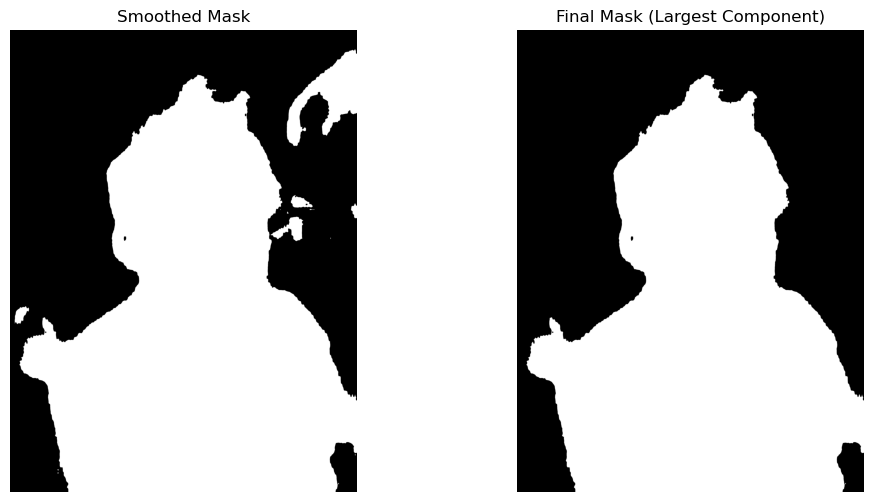

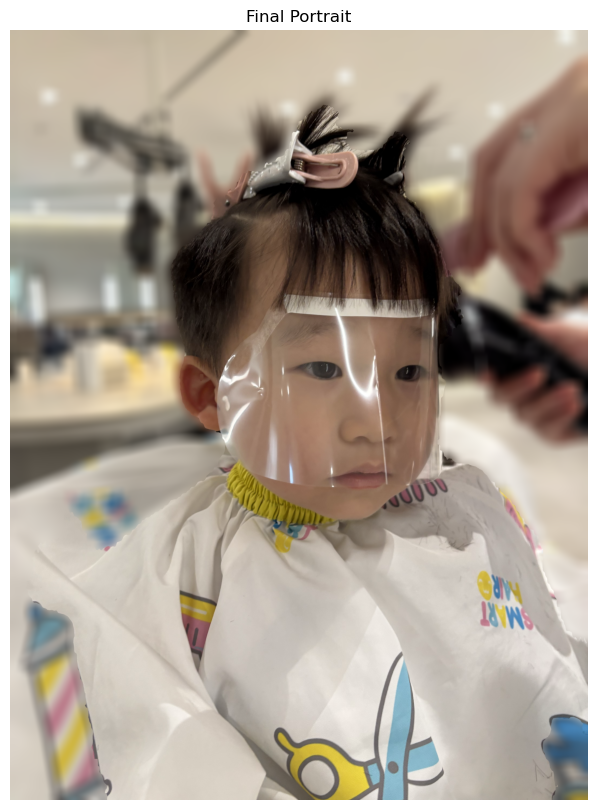

In [15]:
# 덩어리 분석
# num_labels: 발견된 총 객체 수 (배경 포함)
# labels: 각 픽셀에 해당하는 객체 번호(레이블)가 표시된 이미지
# stats: 각 객체의 통계 정보 (x, y, 너비, 높이, 면적 등)
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(smoothed_mask, connectivity=8)

# 가장 큰 덩어리(사람) 탐색
# stats 배열에서 면적(cv2.CC_STAT_AREA) 정보만 추출
# 레이블 0은 배경이므로, 1번부터 시작하는 객체들의 면적을 비교
largest_component_label = np.argmax(stats[1:, cv2.CC_STAT_AREA]) + 1

# 위에서 찾은 가장 큰 덩어리의 레이블로 최종 마스크 생성
final_mask = np.zeros(smoothed_mask.shape, dtype=np.uint8)
# 제일 큰 덩어리의 레이블 값과 일치하는 픽셀만 255로 설정
final_mask[labels == largest_component_label] = 255

# 이전 마스크와 최종 마스크 비교 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(smoothed_mask, cmap='gray')
plt.title('Smoothed Mask')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(final_mask, cmap='gray')
plt.title('Final Mask (Largest Component)')
plt.axis('off')
plt.show()

# 최종 마스크를 이용해 이미지 합성
condition_final = np.stack((final_mask,) * 3, axis=-1) == 255
result_img_final = np.where(condition_final, hard_img, hard_blur_mp)

# 최종 결과 시각화
plt.figure(figsize=(10, 10))
plt.imshow(result_img_final)
plt.title('Final Portrait')
plt.axis('off')
plt.show()

## 9. 오늘의 회고
- 이미지 처리하는게 생각보다 재밌었다. (아직 초보 단계라서 큰 challenge가 별로 없어서 그런거 같긴 하다.)
- 시각적으로 결과물이 바로바로 반영되는게 재밋긴 한듯.
- 이래저래 저런 라이브러리? 모델? 만드시는 분들이 대단
- 마지막에 덩어리 연산으로 가장 큰 것만 남기는걸로 옆에 손이랑 지저분한걸 없애는 방법을 취해봤는데, 혹시나 사람 사진 앞에 장애물? 그런걸로 한사람이 두덩어리로 쪼개지면 잘 안될 것 같기도하다. 그때는 2개를 남기도록 해야되나. 근데 뭐 어떤 방법을 써도 안되는 사진은 나올건데 어디까지 커버해줄건지는 그 뭐라하지? 트레이드 오프 문제 이긴 하겠다.